# Recurrent Neural Network - Univariate
- Simple RNN
- LSTM
- GRU
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

## In order to use LSTM and GRU, you need to downgrade numpy
- `conda create --name tf tensorflow=2.4`
- `conda activate tf`
- `conda install numpy=1.19`
- `conda install jupyterlab matplotlib pandas`
- https://stackoverflow.com/questions/66207609/notimplementederror-cannot-convert-a-symbolic-tensor-lstm-2-strided-slice0-t

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
tf.config.list_physical_devices("GPU")

2022-04-29 19:01:32.405611: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


[]

In [3]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [4]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

In [5]:
# choose a number of time steps
n_steps = 4

In [6]:
# split into samples
X_, y = split_sequence(raw_seq, n_steps)

# visualize input
temp = pd.DataFrame(data=X_, columns=['X1-Time1','X1-Time2','X1-Time3','X1-Time4'])
temp['y'] = y
temp.index.name='sample'
display(temp)

,X1-Time1,X1-Time2,X1-Time3,X1-Time4,y
sample,,,,,
0,10,20,30,40,50
1,20,30,40,50,60
2,30,40,50,60,70
3,40,50,60,70,80
4,50,60,70,80,90


In [7]:
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X_.reshape((X_.shape[0], n_seq, 1, n_steps, n_features))

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, SimpleRNN, GRU, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D

def createModel(type):
    inputLayer = Input(shape=(n_seq, 1, n_steps, n_features))

    if (type == 'ConvLSTM'):
        layer = ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu')(inputLayer)
        layer = Flatten()(layer)
    
    outputLayer = Dense(1)(layer)
    model = Model(inputs=inputLayer, outputs=outputLayer, name=type)

    return model


In [9]:
# Model building
tf.keras.backend.clear_session()
tf.random.set_seed(1)
# For somereason if I don't include this, I cannot execute this cell twice for LSTM and GRU
from tensorflow.keras.layers import LSTM, GRU

ConvLSTM = createModel('ConvLSTM')

ConvLSTM.summary()

Model: "ConvLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 1, 2, 1)]      0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 1, 1, 64)          33536     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


2022-04-29 19:01:32.659224: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-29 19:01:32.662217: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
from tensorflow.keras.callbacks import EarlyStopping

def runModel(model, X, y, **kwargs):

    learning_rate = 0.001
    if 'learning_rate' in kwargs:
        learning_rate = kwargs['learning_rate']

    patience = 10
    if 'patience' in kwargs:
        patience = kwargs['patience']

    epochs=200
    if 'epochs' in kwargs:
        epochs = kwargs['epochs']

    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    earlyStoppingCallback = EarlyStopping(monitor='loss', patience=patience, min_delta=0)

    history = model.fit(X, y, epochs=epochs, verbose=1, callbacks=[earlyStoppingCallback ])

    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15)
    plt.show()

2022-04-29 19:01:32.907251: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-29 19:01:32.924158: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3593185000 Hz


Epoch 1/2000
1/1 [==============================] - 2s 2s/step - loss: 5134.6670
Epoch 2/2000
1/1 [==============================] - 0s 42ms/step - loss: 5053.9941
Epoch 3/2000
1/1 [==============================] - 0s 24ms/step - loss: 4972.5039
Epoch 4/2000
1/1 [==============================] - 0s 79ms/step - loss: 4889.2861
Epoch 5/2000
1/1 [==============================] - 0s 157ms/step - loss: 4804.0039
Epoch 6/2000
1/1 [==============================] - 0s 22ms/step - loss: 4717.9648
Epoch 7/2000
1/1 [==============================] - 0s 42ms/step - loss: 4629.6606
Epoch 8/2000
1/1 [==============================] - 0s 135ms/step - loss: 4540.8291
Epoch 9/2000
1/1 [==============================] - 0s 71ms/step - loss: 4450.1611
Epoch 10/2000
1/1 [==============================] - 0s 39ms/step - loss: 4356.3149
Epoch 11/2000
1/1 [==============================] - 0s 33ms/step - loss: 4260.6514
Epoch 12/2000
1/1 [==============================] - 0s 41ms/step - loss: 4164.7837
E

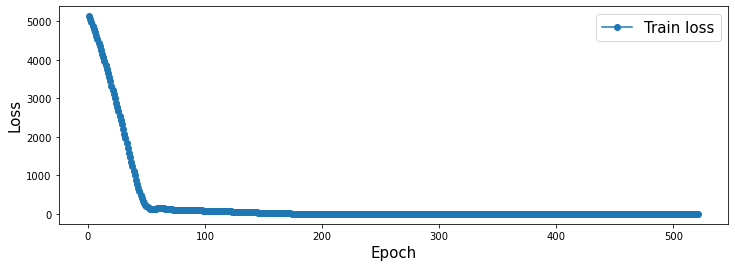

In [11]:
runModel(ConvLSTM, X, y, learning_rate=0.001, epochs=2000, patience=30)

In [12]:
def predictValue(model, X_):
    X = X_.reshape((1, n_seq, 1, n_steps, n_features))
    yhat_ = model.predict(X, verbose=0)
    yhat = yhat_.flatten()[0]
    return yhat

In [13]:
X_ = np.array([60, 70, 80, 90])
print(f"ConvLSTM: {predictValue(ConvLSTM, X_):5.3f}")

ConvLSTM: 101.327
